# Modelling fluid inclusion stretching during stalling
- This notebook shows how to model the stretching of CO2 dominated fluid inclusions in olivine using python tool RelaxiFI (DeVitre and Wieser, 2023; EarthArXiv), implemented in DiadFit. Note that this tool is not designed to model FI with fluids other than CO2 at this time, or those in phases other than olivine. It is based on the model of Wanamaker and Evans, 1989.
- In this example from the RelaxiFI documentation, based on the work from DeVitre and Wieser, 2023 (EarthArXiv), we model the stretching of two CO2 dominated fluid inclusions with 1 and 20 μm radii, trapped at South Caldera Reservoir (Kilaeua volcano, Hawaii) and stored at Halema'uma'u reservoir for 2 years.

## First, make sure CoolProp is installed if using the Span and Wagner 1996 equation of state
- You only need to run this once. If you do not wish to use CoolProp, or face installation problems, please use 'SP94' instead of 'SW96'
- If you have Python installed through Anaconda, you may want to install CoolProp through your conda command line 'conda install conda-forge::coolprop'. Else you can use 'pip install CoolProp' as below. 

In [2]:
#pip install CoolProp

## Next import the necessary packages, including DiadFit

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import DiadFit as pf
pf.__version__

'1.0.8'

In [4]:
from scipy.optimize import fsolve
import numpy as np
import pandas as pd

def invert_denlinger_lerner(D):
    """
    Inverts the denlinger_lerner function to calculate pressure from depth.

    Parameters
    -------------
    D: int, float, pd.Series
        Depth in km

    Returns
    -------------
    Pressure in kbar (same datatype as input)
    """

    def equation(P_kbar, D):
        # Original cubic equation for depth
        return 0.0684 * P_kbar**3 - 0.5008 * P_kbar**2 + 4.47 * P_kbar - D

    def solve_for_P(D_val):
        if D_val > 15:  # No solution for depth > 15 km
            return np.nan
        # Initial guess for fsolve
        initial_guess = 1.0
        P_solution = fsolve(equation, initial_guess, args=(D_val))
        return P_solution[0]

    if isinstance(D, pd.Series):
        return D.apply(solve_for_P)
    else:
        return solve_for_P(D)



In [5]:
Pressure_at_Base=invert_denlinger_lerner(15)
Pressure_to_solve=6-Pressure_at_Base



In [6]:
Depth_to_add=pf.convert_pressure_to_depth(P_kbar=Pressure_to_solve, crust_dens_kgm3=3300, g=9.81)
Depth_tot=Depth_to_add+15
Depth_tot

0    20.566162
dtype: float64

In [7]:
# So Gaffney say 6 kbar
# The denlinger model is calibrated down to 15 km. 

## Now let's model stretching and evaluate how density, pressure and radius change
- We model an FI (5 um) coming from South Caldera (SC) reservoir (4km@ 1300 C) and stalling at Halema'uma'u (HM) reservoir (1km @ 1150 C)


### First, set the PT conditions of the reservoirs

In [8]:
Depth_tot[0]

20.566162215605267

In [9]:
####### Establish reservoir PTX conditions

## Choose an equation of state and crustal density model for the calculations
EOS='SW96'
crustal_model_config=pf.config_crustalmodel(model='ryan_lerner') # this configures the crustal model to be used

## SC reservoir conditions
Trapping_depth = Depth_tot[0] # Average depth of the South Caldera reservoir in km
melt_MgO=13 #melt MgO in wt% 
Trapping_temp=round(21.2*melt_MgO+1017,-1)  # Temperature in C at South Caldera reservoir (MgO thermometry, see DeVitre and Wieser, 2023, Shea 2022)
# find pressure @ SC
tolerance = 0.001 # How close we want to be to the target pressure
Trapping_pressure =6 #  

## HM reservoir conditions
Storage_depth = 3 # Average depth of the Halema'uma'u reservoir in km
melt_MgO=6.5 #melt MgO in wt%
Storage_temp=round(21.2*melt_MgO+1017,-1)  # Temperature in C at Halema'uma'u reservoir (MgO thermometry)
# find pressure @ HM
tolerance = 0.01 # How close we want to be to the target pressure
Storage_pressure = pf.find_P_for_kmdepth(target_depth_km=Storage_depth, 
                            crustal_model_config=crustal_model_config, tolerance=tolerance)[0] #This is the calculated pressure at Halema'uma'u reservoir



In [10]:
Storage_temp

1150.0

In [11]:
Storage_pressure

0.6834124545503082

In [12]:

pf.calculate_rho_for_P_T(EOS=EOS,P_kbar=Storage_pressure,T_K=Storage_temp+273.15)[0]


0.21729066945164116

### Next, Calculate CO2 density (trapped at SC) and internal pressure adjusted to HM reservoir

In [13]:
### First let's calculate the CO2 density of our 5um FI trapped at SC
fi_rho_initial_gcm3=pf.calculate_rho_for_P_T(EOS=EOS,P_kbar=Trapping_pressure,T_K=Trapping_temp+273.15)[0]

## Now we move the FI to HM reservoir (1km), Pinternal will change bc T is lower than at SC, we recalculate Pinternal
fi_Pi_storage_initial_MPa=pf.calculate_P_for_rho_T(EOS=EOS,CO2_dens_gcm3=fi_rho_initial_gcm3,T_K=Storage_temp+273.15)['P_MPa'][0]


### With that, set the initial internal pressure for the model and external pressure (HM)

In [14]:
Pinternal=fi_Pi_storage_initial_MPa # Internal pressure of the FI in MPa
Pexternal=Storage_pressure*100 ## External Pressure in the HM reservoir in MPa 

### Set stalling time (2 years), FI radii (here 1 um and 20 um), and distances from crystal defects (cracks, rims)

In [15]:
# Set stalling time
years=10 # choose number of years for stalling
totaltime=years*365.25*24*60*60 # this is the totaltime of stalling in s (must be in seconds for model calculations)

# Set the FI radius (meters)
R0 = 1.5 * 10 ** -6 # FI radius in m, here 1 micron #this is the minimum
R1 = 30 * 10 ** -6 # FI radius in m, here 1 micron # this is the median size
R2 = 8 * 10 ** -6 # FI radius in m, here 1 micron
# The 16th quantile (halfed) from the linear intercept distances is 36 um, median = 83, and upper 84th quantile = 152
dist2defect_list=[100, 200] # Distances to crystal defect structures (cracks, rim) in microns

R_values = [R0,R1, R2]  # Define R values, if there is more than one R, add them to the list. 
b_values=[b*10**-6 for b in dist2defect_list] # make sure the bvalues are in meters. 



### Choose calculation parameters

In [16]:
method='RK1' # this is the numerical solver, options are RK1, RK2, RK3 and RK4 (RK1 is the same as Euler method, RK2 same as Heun)
steps=3000 #number of steps, more is better but slower

In [17]:
print(Pinternal)
print(Pexternal)

544.27272717941
68.34124545503082


### Now let's run the model 

In [18]:
results_dict_Exp = pf.loop_R_b_constant_Pext(R_m_values=R_values, b_m_values=b_values, T_K=Storage_temp+273.15, EOS=EOS, Pinternal_MPa=Pinternal, Pexternal_MPa=Pexternal, 
                                                    totaltime_s=totaltime, steps=steps, T4endcalc_PD=Trapping_temp,method=method,
                                              plotfig=False,crustal_model_config=crustal_model_config, step_type='exponential', max_perc_change=0.5)

Reducing step size, as pressure change was more than 0.5%.
Reducing step size, as pressure change was more than 0.5%.
Reducing step size, as pressure change was more than 0.5%.
Reducing step size, as pressure change was more than 0.5%.
Reducing step size, as pressure change was more than 0.5%.
Reducing step size, as pressure change was more than 0.5%.
Reducing step size, as pressure change was more than 0.5%.
Reducing step size, as pressure change was more than 0.5%.
Reducing step size, as pressure change was more than 0.5%.
Reducing step size, as pressure change was more than 0.5%.
Reducing step size, as pressure change was more than 0.5%.
Reducing step size, as pressure change was more than 0.5%.
Reducing step size, as pressure change was more than 0.5%.
Reducing step size, as pressure change was more than 0.5%.
Reducing step size, as pressure change was more than 0.5%.
Reducing step size, as pressure change was more than 0.5%.
Reducing step size, as pressure change was more than 0.5

In [19]:
results_dict_Exp_small = pf.loop_R_b_constant_Pext(R_m_values=[R1], b_m_values=b_values, T_K=Storage_temp+273.15, EOS=EOS, Pinternal_MPa=Pinternal, Pexternal_MPa=Pexternal, 
                                                    totaltime_s=totaltime, steps=10000, T4endcalc_PD=Trapping_temp,method=method,
                                              plotfig=False,crustal_model_config=crustal_model_config, step_type='exponential', max_perc_change=0.5)

## Load timescales to plot

In [20]:
K23=pd.read_excel(r'C:\Users\penny\Box\Berkeley_new\Raman\MaunaLoa\MaunaLoaTimescales_literature.xlsx', sheet_name='Kahl2023')
C22=pd.read_excel(r'C:\Users\penny\Box\Berkeley_new\Raman\MaunaLoa\MaunaLoaTimescales_literature.xlsx', sheet_name='Couperthwaite2022')
C20=pd.read_excel(r'C:\Users\penny\Box\Berkeley_new\Raman\MaunaLoa\MaunaLoaTimescales_literature.xlsx', sheet_name='Couperthwaite2020')
L24=pd.read_excel(r'C:\Users\penny\Box\Berkeley_new\Raman\MaunaLoa\MaunaLoaTimescales_literature.xlsx', sheet_name='Lynn2024')

## Load Pressures to plot

In [31]:
Pressures=pd.read_excel('MaunaLoaTimescales_literature.xlsx', sheet_name='Pressures')
data1=Pressures['P_kbar_xenoliths']
data2=Pressures['P_kbar_extrusives']


# Concatenate into a single Series
data = pd.concat([data1, data2], ignore_index=True)

# Create a DataFrame with the combined data
df_p = pd.DataFrame({'P(kbar)_HC': data})

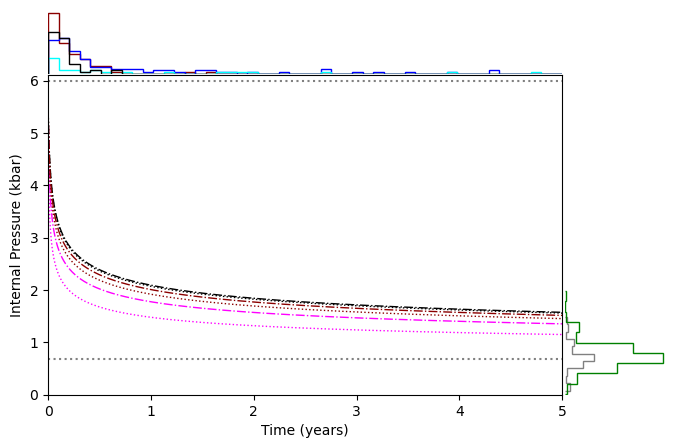

In [32]:
################## Now let's plot our results ######################

time2years=totaltime/years

# Define some constants and variables

y_col = 'Pinternal(MPa)'
x_col = 'Time(s)'
xlabel4plot = 'Time (years)'
ylabel4plot = 'Internal Pressure (kbar)'
twinlabel4plot = 'Deviation from Entrapment Pressure (%)'
linecolor = 'magenta'
linecolor3='darkred'
linecolor2 = 'black'
linewidth = 1

# Create a figure and axes



fig, ((ax3a, deadspace), (ax, ax2_hist)) = plt.subplots(
    2, 2, figsize=(8, 5), 
    gridspec_kw={'width_ratios': [3, 0.6], 'height_ratios': [0.6, 3, ], 'wspace': 0.01, 'hspace': 0.01}, 
)

ax2_hist.axes.get_xaxis().set_visible(False)
ax2_hist.axes.get_yaxis().set_visible(False)
ax2_hist.axis("off")

deadspace.axes.get_xaxis().set_visible(False)
deadspace.axes.get_yaxis().set_visible(False)
deadspace.axis("off")


bins = np.linspace(0, 5, num=50)  # Adjust 'num' for the number of bins


ax3a.hist(K23['Timescale  (days)']/365, bins=bins, edgecolor='darkred', linewidth=1, histtype='step')
ax3a.hist(C22['Timescale (days)']/365, bins=bins, edgecolor='blue', linewidth=1, histtype='step')
ax3a.hist(C20['Timescale(days)']/365, bins=bins, edgecolor='cyan', linewidth=1, histtype='step')
ax3a.hist(L24['Timescale (Median)']/365, bins=bins, edgecolor='k', linewidth=1, histtype='step')
# Plot the data on the primary y-axis

ax.plot(results_dict_Exp['R0']['b0'][x_col] /time2years, results_dict_Exp['R0']['b0'][y_col]/100, color=linecolor2, linestyle=':', linewidth=linewidth, label=str(dist2defect_list[0]))
ax.plot(results_dict_Exp['R0']['b1'][x_col] /time2years, results_dict_Exp['R0']['b1'][y_col]/100, color=linecolor2, linestyle='-.', linewidth=linewidth, label=str(dist2defect_list[1]))

ax.plot(results_dict_Exp_small['R0']['b0'][x_col] /time2years, results_dict_Exp_small['R0']['b0'][y_col]/100, color=linecolor, linestyle=':', linewidth=linewidth)
ax.plot(results_dict_Exp_small['R0']['b1'][x_col] /time2years, results_dict_Exp_small['R0']['b1'][y_col]/100, color=linecolor, linestyle='-.', linewidth=linewidth)

ax.plot(results_dict_Exp['R2']['b0'][x_col] /time2years, results_dict_Exp['R2']['b0'][y_col]/100, color=linecolor3, linestyle=':', linewidth=linewidth)
ax.plot(results_dict_Exp['R2']['b1'][x_col] /time2years, results_dict_Exp['R2']['b1'][y_col]/100, color=linecolor3, linestyle='-.', linewidth=linewidth)




xlim=([round(min(results_dict_Exp['R1']['b0'][x_col]/time2years)),round(max(results_dict_Exp['R1']['b0'][x_col]/time2years))])
ymin=np.nanmin([np.nanmin(results_dict_Exp['R1']['b0'][y_col])])

ylim=[ymin,fi_rho_initial_gcm3]

ylim_P=pf.calculate_P_for_rho_T(EOS=EOS,CO2_dens_gcm3=pd.Series(ylim),T_K=Trapping_temp+273.15)['P_MPa']

ax2_hist.hist(df_FI_Gaff['P(kbar)_HC'], orientation='horizontal', edgecolor='grey', linewidth=1, histtype='step')
ax2_hist.hist(df_FI_ML['P(kbar)_HC'], orientation='horizontal', edgecolor='green', linewidth=1, histtype='step')

# Customize axis labels and legends

ax.set_xlabel(xlabel4plot)
ax.set_ylabel(ylabel4plot)


#ax.legend(title='Distance to crystal defect (μm)')

ax.plot([0, 5], [Storage_pressure, Storage_pressure], ':', color='grey')
ax.plot([0, 5], [Trapping_pressure, Trapping_pressure], ':', color='grey')

ax.set_xlim([0, 5])
ax3a.set_xlim([0, 5])

ax3a.axes.get_xaxis().set_visible(False)
ax3a.axes.get_yaxis().set_visible(False)
ax3a.set_xlim([0, 5])
ax3a.set_xlim([0, 5])
ax3a.axis("off")

ax.set_ylim([0, 6.1])
ax2_hist.set_ylim([0, 6.1])

fig.savefig('MaunaLoa_Reeq.png', dpi=300)

In [ ]:
df_FI_Gaff['P(kbar)_HC'].loc[~(df_FI_Gaff['eruption']=='7360')]

0     0.734286
1     0.756978
2     0.766303
3     0.710009
4     0.726715
        ...   
75    0.558153
76    0.645260
77    0.496399
78    0.663104
79    1.023090
Name: P(kbar)_HC, Length: 77, dtype: float64

## Lets try using a log scale for better visualizatoin of the early years

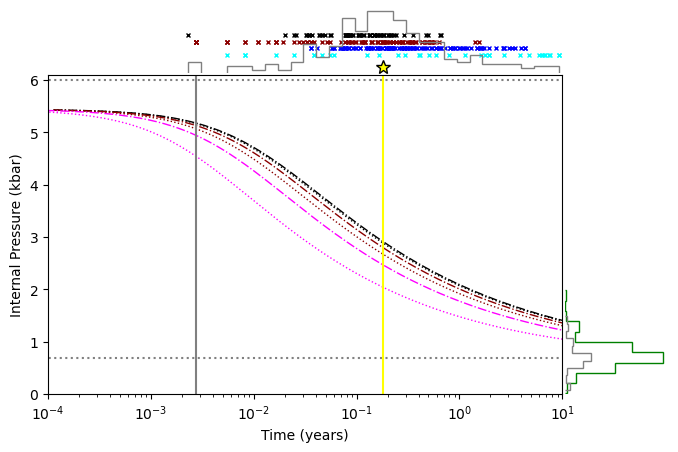

In [33]:
################## Now let's plot our results ######################

time2years=totaltime/years

# Define some constants and variables

y_col = 'Pinternal(MPa)'
x_col = 'Time(s)'
xlabel4plot = 'Time (years)'
ylabel4plot = 'Internal Pressure (kbar)'
twinlabel4plot = 'Deviation from Entrapment Pressure (%)'
linecolor = 'magenta'
linecolor3='darkred'
linecolor2 = 'black'
linewidth = 1

# Create a figure and axes



fig, ((ax3a, deadspace), (ax, ax2_hist)) = plt.subplots(
    2, 2, figsize=(8, 5), 
    gridspec_kw={'width_ratios': [3, 0.6], 'height_ratios': [0.6, 3, ], 'wspace': 0.01, 'hspace': 0.01}, 
)

ax2_hist.axes.get_xaxis().set_visible(False)
ax2_hist.axes.get_yaxis().set_visible(False)
ax2_hist.axis("off")

deadspace.axes.get_xaxis().set_visible(False)
deadspace.axes.get_yaxis().set_visible(False)
deadspace.axis("off")






# Plot the data on the primary y-axis

ax.plot(results_dict_Exp['R0']['b0'][x_col] /time2years, results_dict_Exp['R0']['b0'][y_col]/100, color=linecolor2, linestyle=':', linewidth=linewidth, label=str(dist2defect_list[0]))
ax.plot(results_dict_Exp['R0']['b1'][x_col] /time2years, results_dict_Exp['R0']['b1'][y_col]/100, color=linecolor2, linestyle='-.', linewidth=linewidth, label=str(dist2defect_list[1]))

# ax.plot(results_dict_Exp['R1']['b0'][x_col] /time2years, results_dict_Exp['R1']['b0'][y_col]/100, color=linecolor, linestyle=':', linewidth=linewidth)
# ax.plot(results_dict_Exp['R1']['b1'][x_col] /time2years, results_dict_Exp['R1']['b1'][y_col]/100, color=linecolor, linestyle='-.', linewidth=linewidth)

ax.plot(results_dict_Exp['R2']['b0'][x_col] /time2years, results_dict_Exp['R2']['b0'][y_col]/100, color=linecolor3, linestyle=':', linewidth=linewidth)
ax.plot(results_dict_Exp['R2']['b1'][x_col] /time2years, results_dict_Exp['R2']['b1'][y_col]/100, color=linecolor3, linestyle='-.', linewidth=linewidth)


ax.plot(results_dict_Exp_small['R0']['b0'][x_col] /time2years, results_dict_Exp_small['R0']['b0'][y_col]/100, color=linecolor, linestyle=':', linewidth=linewidth)
ax.plot(results_dict_Exp_small['R0']['b1'][x_col] /time2years, results_dict_Exp_small['R0']['b1'][y_col]/100, color=linecolor, linestyle='-.', linewidth=linewidth)





xlim=([round(min(results_dict_Exp['R1']['b0'][x_col]/time2years)),round(max(results_dict_Exp['R1']['b0'][x_col]/time2years))])
ymin=np.nanmin([np.nanmin(results_dict_Exp['R1']['b0'][y_col])])

ylim=[ymin,fi_rho_initial_gcm3]

ylim_P=pf.calculate_P_for_rho_T(EOS=EOS,CO2_dens_gcm3=pd.Series(ylim),T_K=Trapping_temp+273.15)['P_MPa']

## This is the pressures. 

array_xenolith=df_FI_Gaff['P(kbar)_HC'].loc[~(df_FI_Gaff['eruption']=='7360')]


array_historic=pd.concat([df_FI_Gaff['P(kbar)_HC'].loc[df_FI_Gaff['eruption']=='7360'],
                     df_FI_ML['P(kbar)_HC']]
                     )




ax2_hist.hist(array_historic, orientation='horizontal', edgecolor='green', linewidth=1, histtype='step')
ax2_hist.hist(array_xenolith, orientation='horizontal', edgecolor='grey', linewidth=1, histtype='step')

# Customize axis labels and legends

ax.set_xlabel(xlabel4plot)
ax.set_ylabel(ylabel4plot)


#ax.legend(title='Distance to crystal defect (μm)')

ax.plot([0, 10], [Storage_pressure, Storage_pressure], ':', color='grey')
ax.plot([0, 10], [Trapping_pressure, Trapping_pressure], ':', color='grey')

ax.set_xlim([0, 5])
ax3a.set_xlim([0, 5])

ax3a.axes.get_xaxis().set_visible(False)
ax3a.axes.get_yaxis().set_visible(False)
ax3a.set_xlim([0, 5])
ax3a.set_xlim([0, 5])
ax3a.axis("off")

ax.set_ylim([0, 6.1])
ax2_hist.set_ylim([0, 6.1])

## Lets plot the timescales as dots

# ax3a.hist(K23['Timescale  (days)']/365, bins=bins, edgecolor='darkred', linewidth=1, histtype='step')
# ax3a.hist(C22['Timescale (days)']/365, bins=bins, edgecolor='blue', linewidth=1, histtype='step')
# ax3a.hist(C20['Timescale(days)']/365, bins=bins, edgecolor='cyan', linewidth=1, histtype='step')
# ax3a.hist(L24['Timescale (Median)']/365, bins=bins, edgecolor='k', linewidth=1, histtype='step')
ms1=3
ax3a.plot(L24['Timescale (Median)']/365, L24['Timescale (Median)']/365*0+18, 'x',ms=ms1,  color='k', label='2024')
ax3a.plot(K23['Timescale  (days)']/365, K23['Timescale  (days)']/365*0+15, 'x',  ms=ms1, color='darkred', label='1950')
ax3a.plot(C22['Timescale (days)']/365, C22['Timescale (days)']/365*0+12, 'x', ms=ms1, color='blue', label='240')
ax3a.plot(C20['Timescale(days)']/365, C20['Timescale(days)']/365*0+9, 'x',ms=ms1,  color='cyan', label='2.1 ka')

Allt=np.concatenate([K23['Timescale  (days)'].values/365,C22['Timescale (days)'].values/365, C20['Timescale(days)'].values/365, L24['Timescale (Median)'].values/365 ])
ax3a.plot(np.nanmedian(Allt), 3.5, '*k', mfc='yellow', ms=10)
ax3a.set_ylim([0.8, 30])
bins = np.logspace(np.log10(min(Allt)), np.log10(max(Allt)), 30)  # 50 bins

ax3a.hist(Allt, bins=bins, edgecolor='grey', linewidth=1, histtype='step')

# Lets plot 24 hrs
ax.plot([1/365, 1/365], [0, 6.1], '-', color='grey')
ax.plot([np.nanmedian(Allt), np.nanmedian(Allt)], [0, 6.1], '-', color='yellow')
ax.set_xscale('log')
ax3a.set_xscale('log')
ax.set_xlim([0.0001, 10])
ax3a.set_xlim([0.0001, 10])
fig.savefig('MaunaLoa_Reeqlog.png', transparent=True, dpi=300)